# PSF Matching Kernels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

from mophongo.psf_map import PSFRegionMap
import mophongo.psf
importlib.reload(mophongo.psf)
from mophongo.psf import DrizzlePSF, PSF
from astropy.io import fits




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


2186 1523


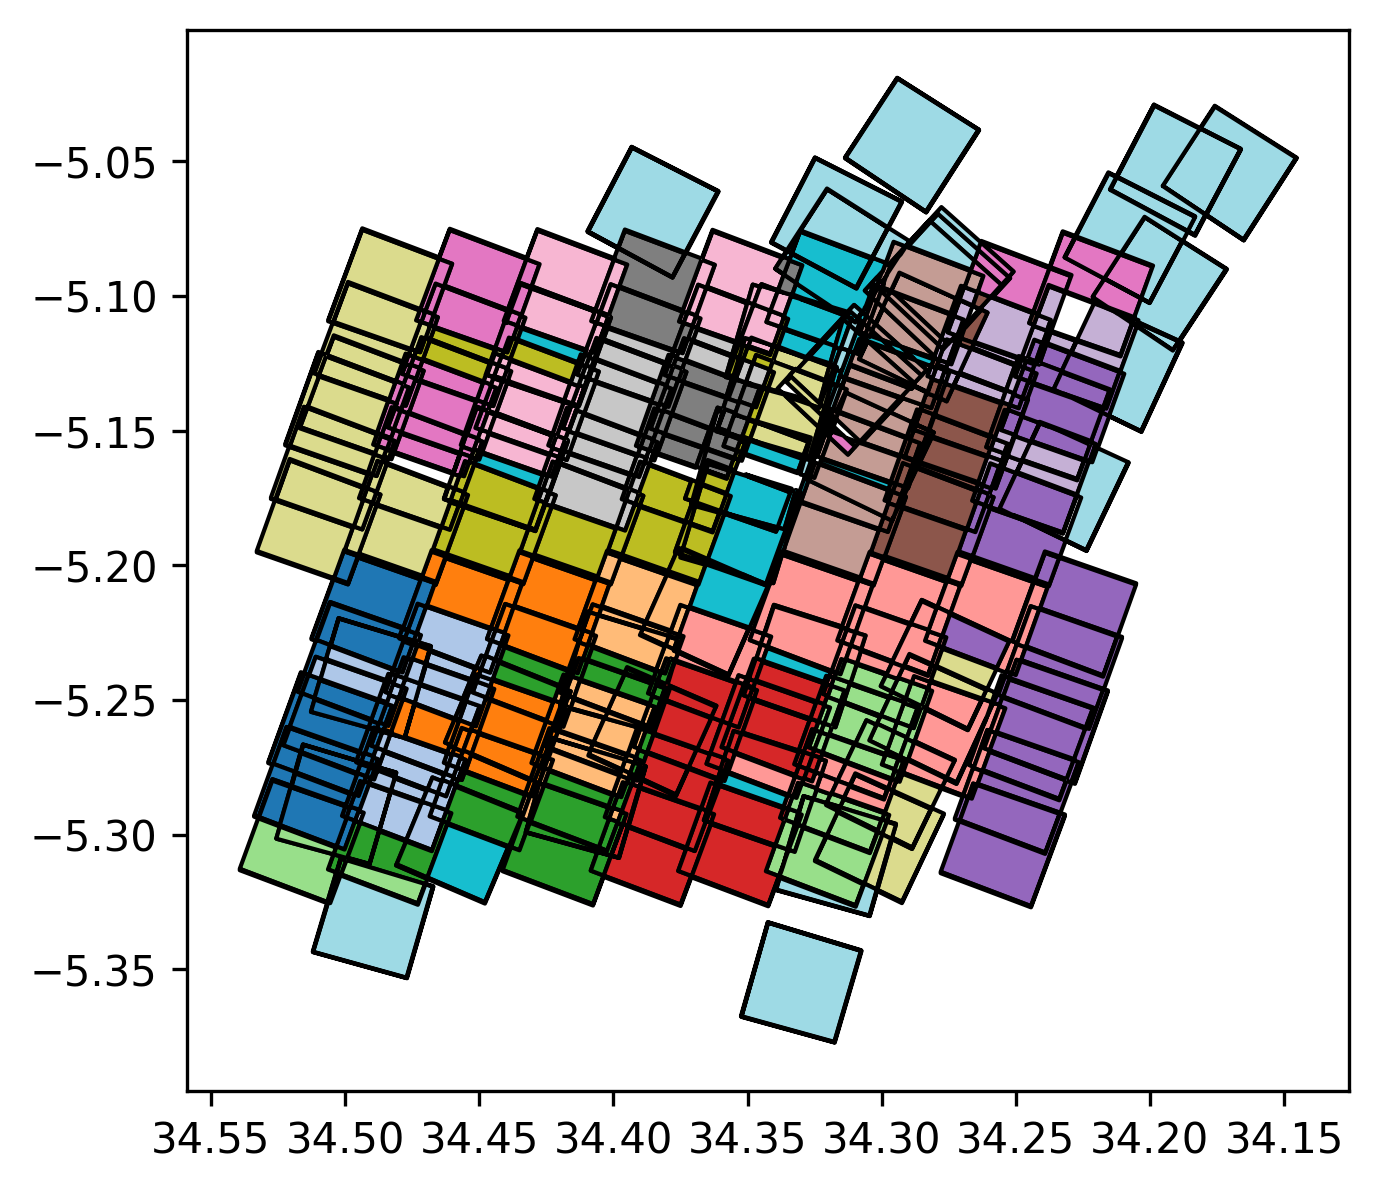

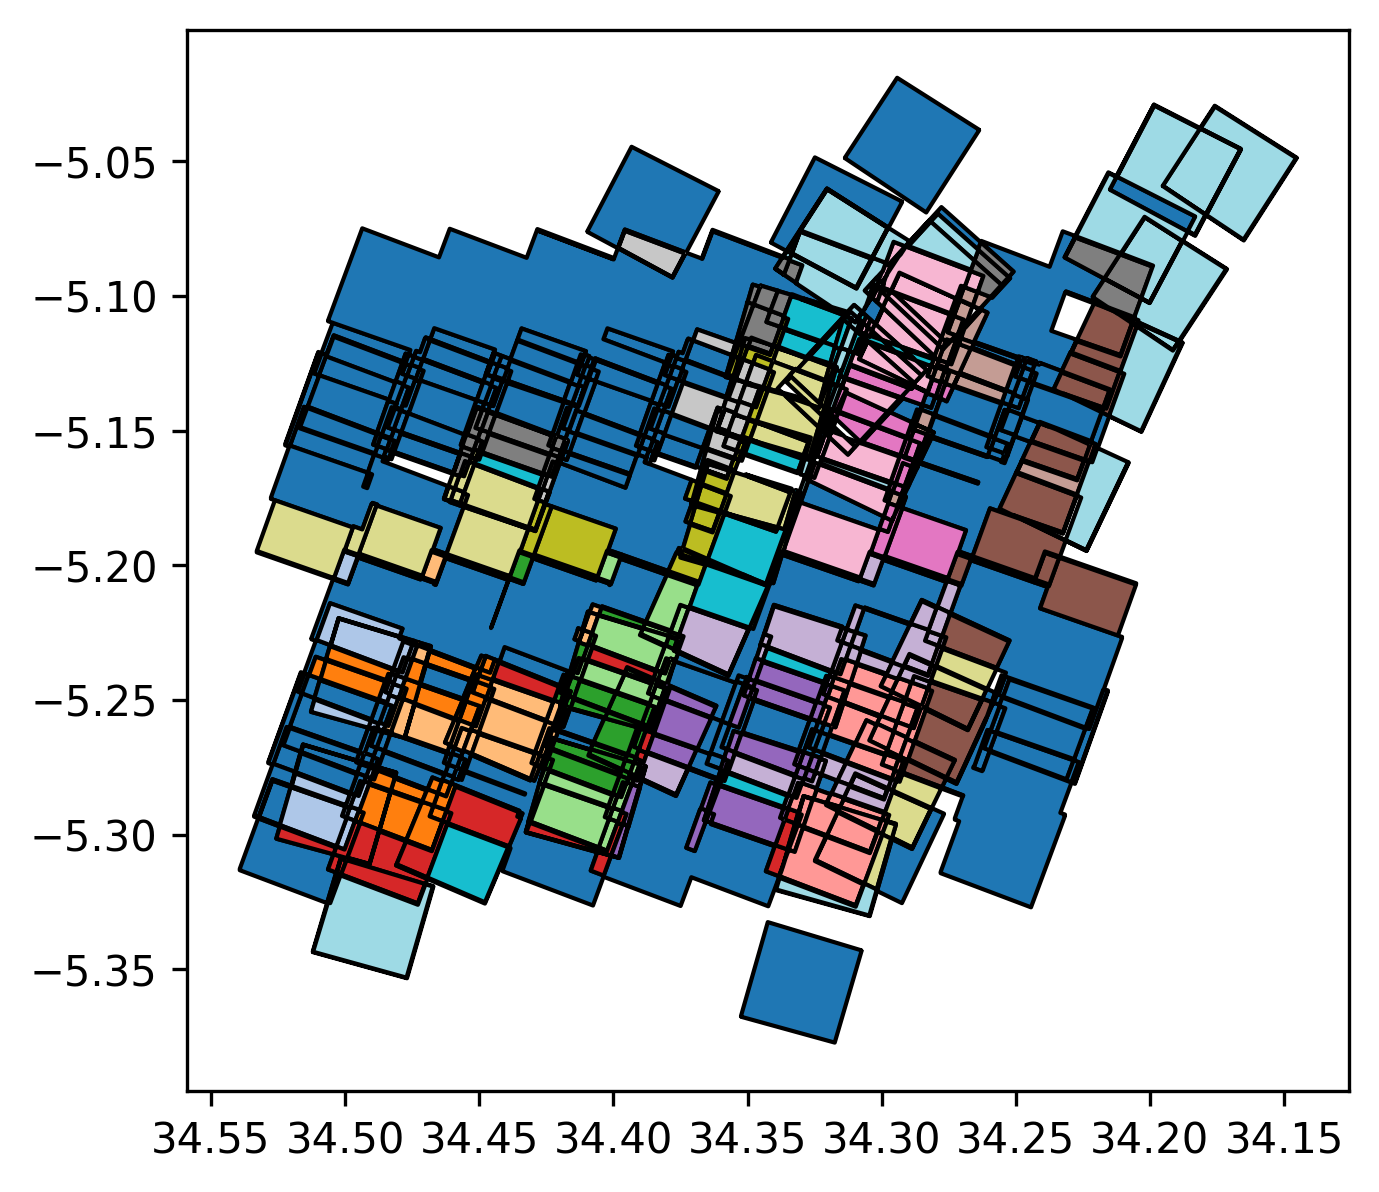

In [ ]:
field = 'uds-test'
filt = 'F444W'
data_dir = Path('../data')
drz_file = data_dir / f'{field}-{filt.lower()}_sci.fits'

dpsf = DrizzlePSF(driz_image=str(drz_file))

footprints = {k: v for i, (k, v) in enumerate(dpsf.footprint.items())  if (i>=0 and i<1000)}

prm = PSFRegionMap.from_footprints(footprints, buffer_tol=1.0/3600, area_factor=50)

prm.plot()

prma = prm.group_by_pa(pa_tol=1.0, hdrs=dpsf.hdrs)

prma.plot()

print(len(prm.regions),len(prma.regions))

## Create PSF cubes for both filters

Loading ../data/PSF/UDS_NRCB5_F444W_OS4_GRID1.fits 260x260x1 NIRCam NRCB5 F444W 59967.2
Loading ../data/PSF/UDS_NRCA5_F444W_OS4_GRID1.fits 260x260x1 NIRCam NRCA5 F444W 59967.2
number of regions None 6
Loading ../data/PSF/UDS_MIRI_F770W_OS4_GRID1.fits 292x292x1 MIRI MIRIM F770W 59967.1
number of regions None 1


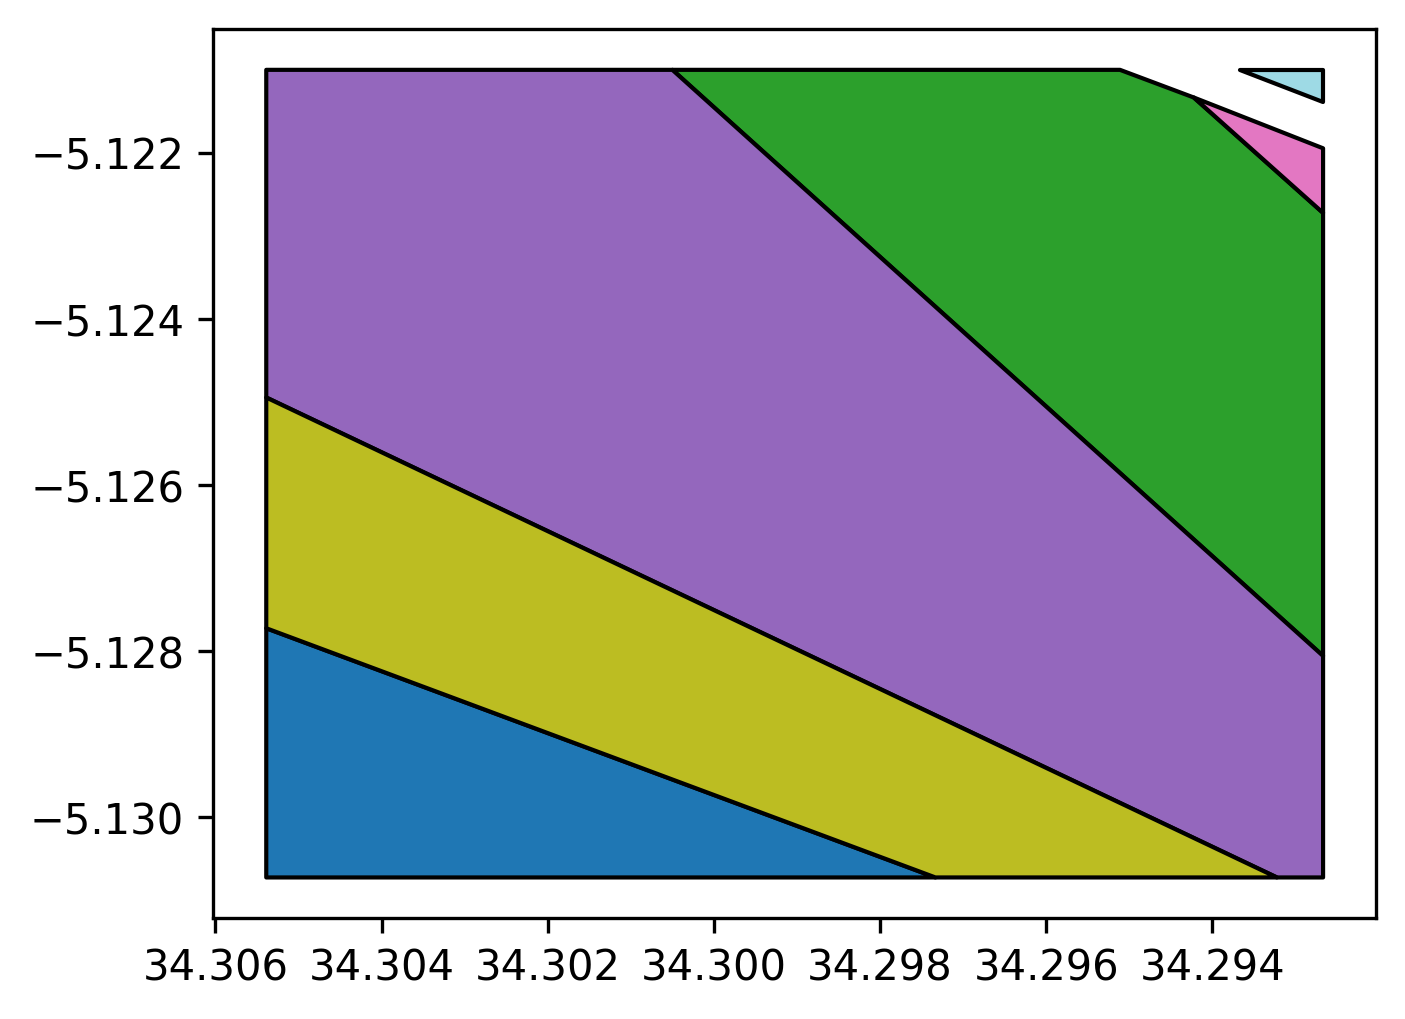

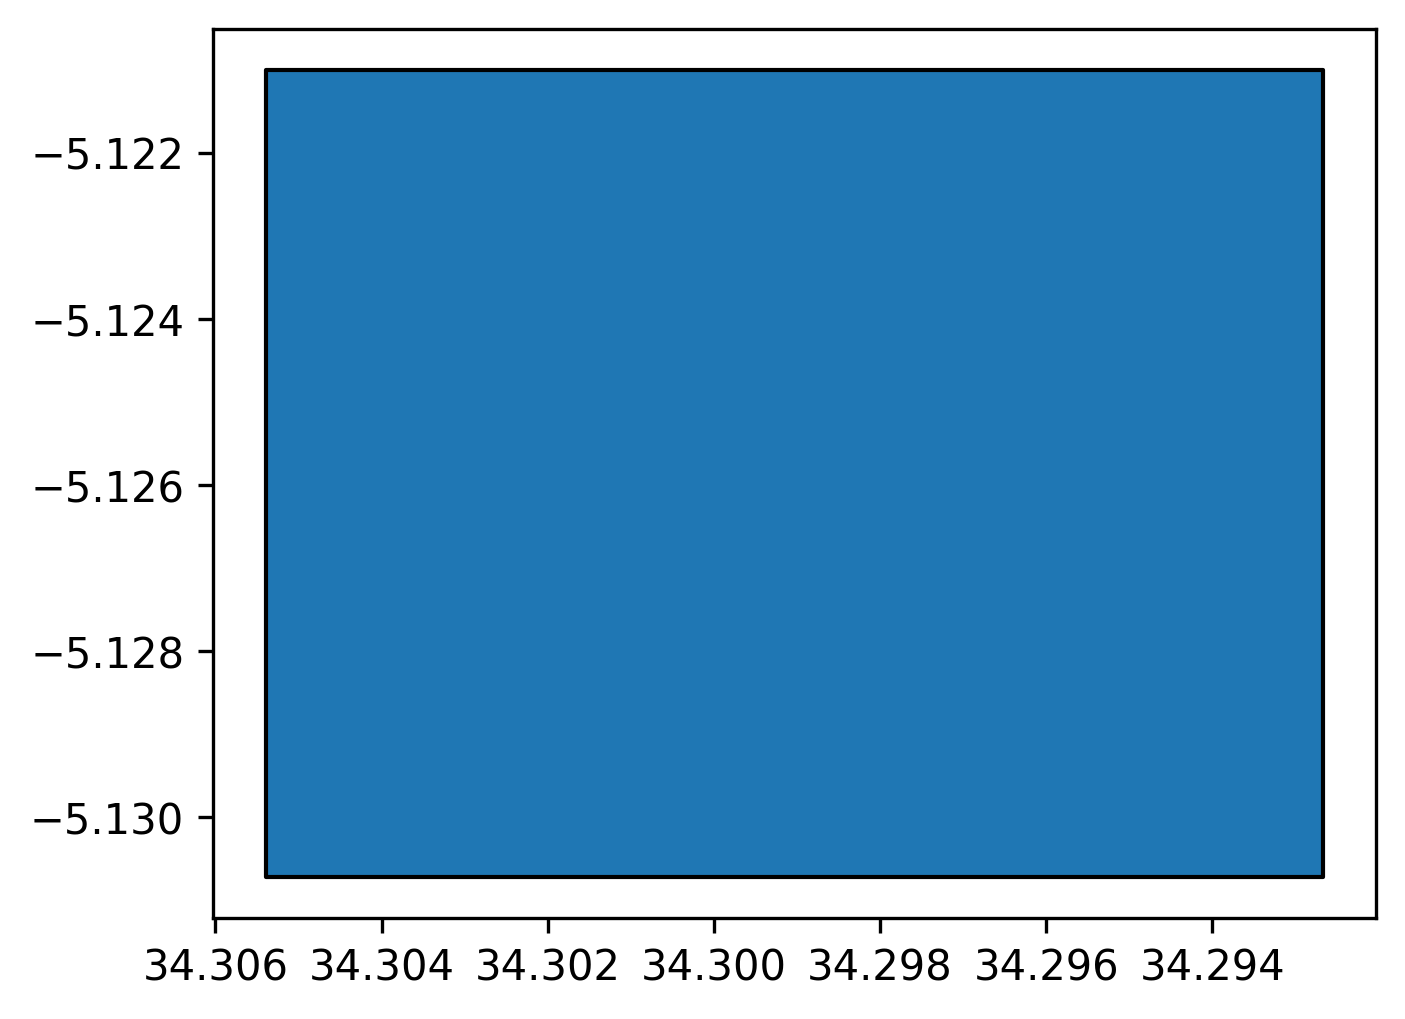

In [2]:
field= 'uds-test'
data_dir = Path('../data')
psf_dir = data_dir / 'PSF'
filters = [('F444W', 'UDS_NRC.._F444W_OS4_GRID1'),
           ('F770W', 'UDS_MIRI_F770W_OS4_GRID1')]
size = 201

prms = []
psf_cubes = {}
for filt, filt_key in filters:
    drz_file = data_dir / f'{field}-{filt.lower()}_sci.fits'

    # initialize Drizzler and EPSF object
    dpsf = DrizzlePSF(driz_image=str(drz_file))
    dpsf.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=filt_key, verbose=True)

    # only overlapping footprints with mosaic
    footprints = {k: v for k, v in dpsf.footprint.items() if v.intersects(dpsf.driz_footprint)}

    # section overlapping frames into unique areas  
    prm = PSFRegionMap.from_footprints(footprints, name=filt)
    # merge those with same PA and relative detector exposure time profile, over the mosaic footprint
    prmfa = prm.group_by_pa(pa_tol=1.0, hdrs=dpsf.hdrs).overlay_with(dpsf.driz_footprint)
    prms.append(prmfa)

    ax = prmfa.plot()

    # get PSFs for all psf_keys
    pos = [np.squeeze(p.xy) for p in prmfa.regions.geometry.centroid]
    idx = prmfa.regions.psf_key.to_numpy()
    print('number of regions', prmfa.name, len(pos))

    # get the drizzled PSF for each region, store in indexed cube      
    prmfa.psfs = dpsf.get_psf_radec(pos, filt_key, size=size, verbose=True)    

    # save the region map to geojson and PSFs to a FITS file
    prmfa.to_file(data_dir / f'{field}_{filt}_psf.geojson')


## Compute matching kernels

,geometry,psf_key_1,psf_key_2,psf_key
0,"POLYGON ((34.30539 -5.13072, 34.29733 -5.13072...",0,0,0
1,"POLYGON ((34.29511 -5.121, 34.3005 -5.121, 34....",1,0,1
2,"POLYGON ((34.30539 -5.121, 34.30539 -5.12494, ...",2,0,2
3,"POLYGON ((34.29267 -5.12194, 34.29422 -5.12133...",3,0,3
4,"POLYGON ((34.30539 -5.12772, 34.29733 -5.13072...",4,0,4
5,"POLYGON ((34.29267 -5.121, 34.29367 -5.121, 34...",5,0,5


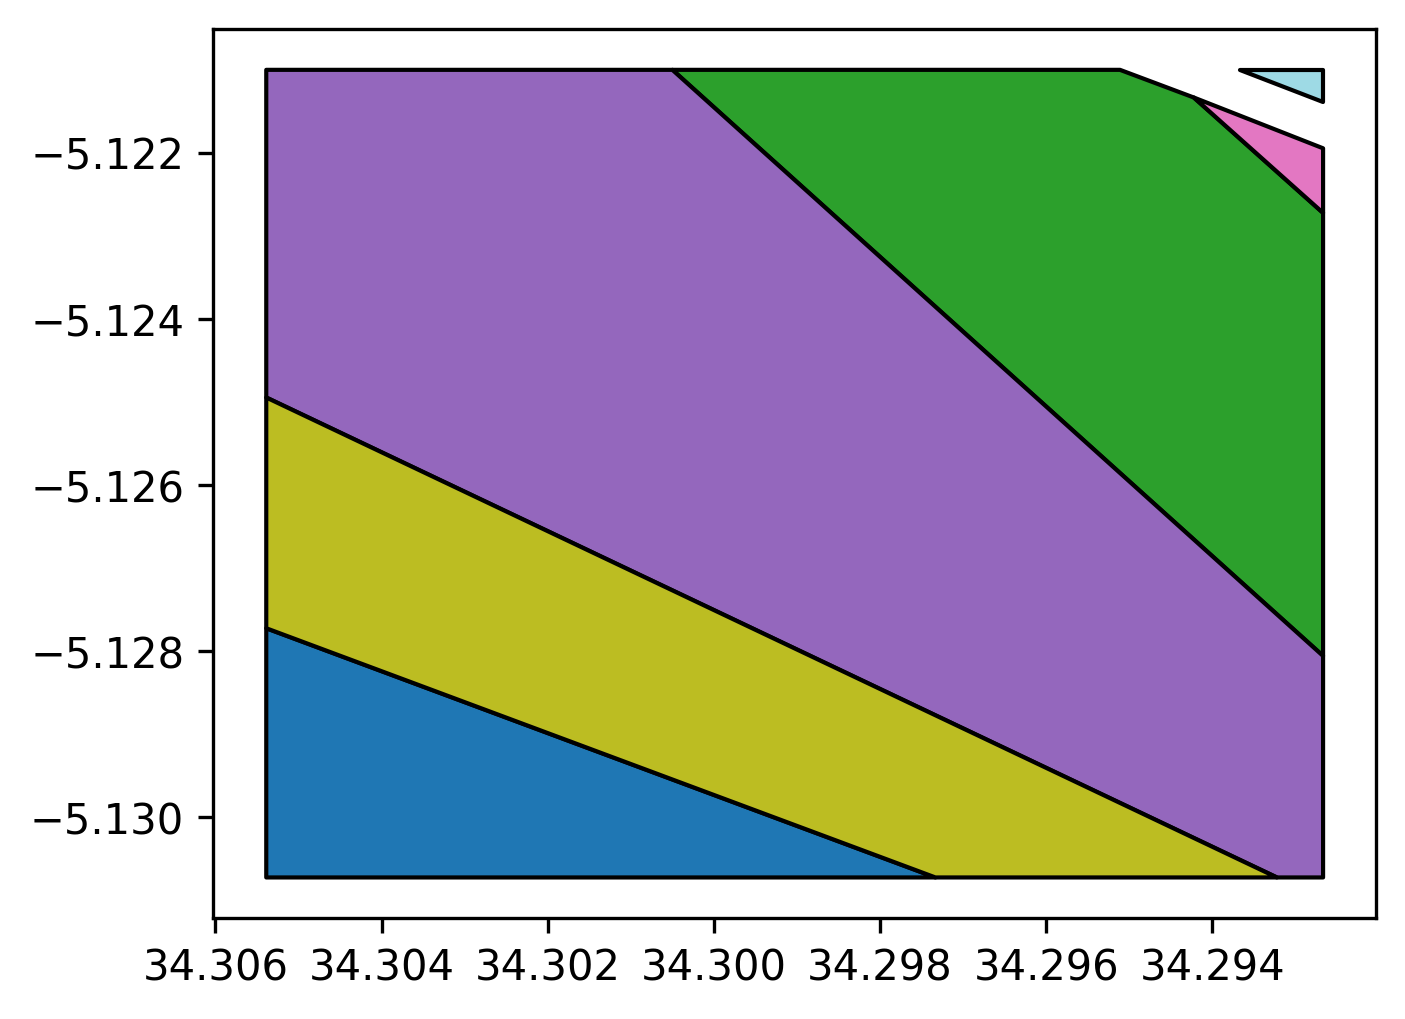

In [4]:
from mophongo.psf import psf_matching_kernel
from photutils.psf.matching import SplitCosineBellWindow

# compute the unique overlay map for both filters, tracking which kernels are unique
prm444_to_777 = prms[0].overlay_with(prms[1])
prm444_to_777.plot()
# window for convolution kernel
window=SplitCosineBellWindow(alpha=0.4, beta=0.1)

# for all regions, compute the PSF matching kernel
kernels = []
for idx, r in prm444_to_777.regions.iterrows():
    psf1 = prms[0].psfs[r.psf_key_1]
    psf2 = prms[1].psfs[r.psf_key_2]
    kernels.append(psf_matching_kernel(psf1, psf2, window=window))

prm444_to_777.psfs = np.array(kernels)

# save the regions to a GeoJSON file and the PSFS to a FITS cube
prm444_to_777.to_file(data_dir / f'{field}_kernel_f444w_to_f770w.geojson')

prm444_to_777.regions

0 34.3027037037037 -5.129722222222222 0 0 0


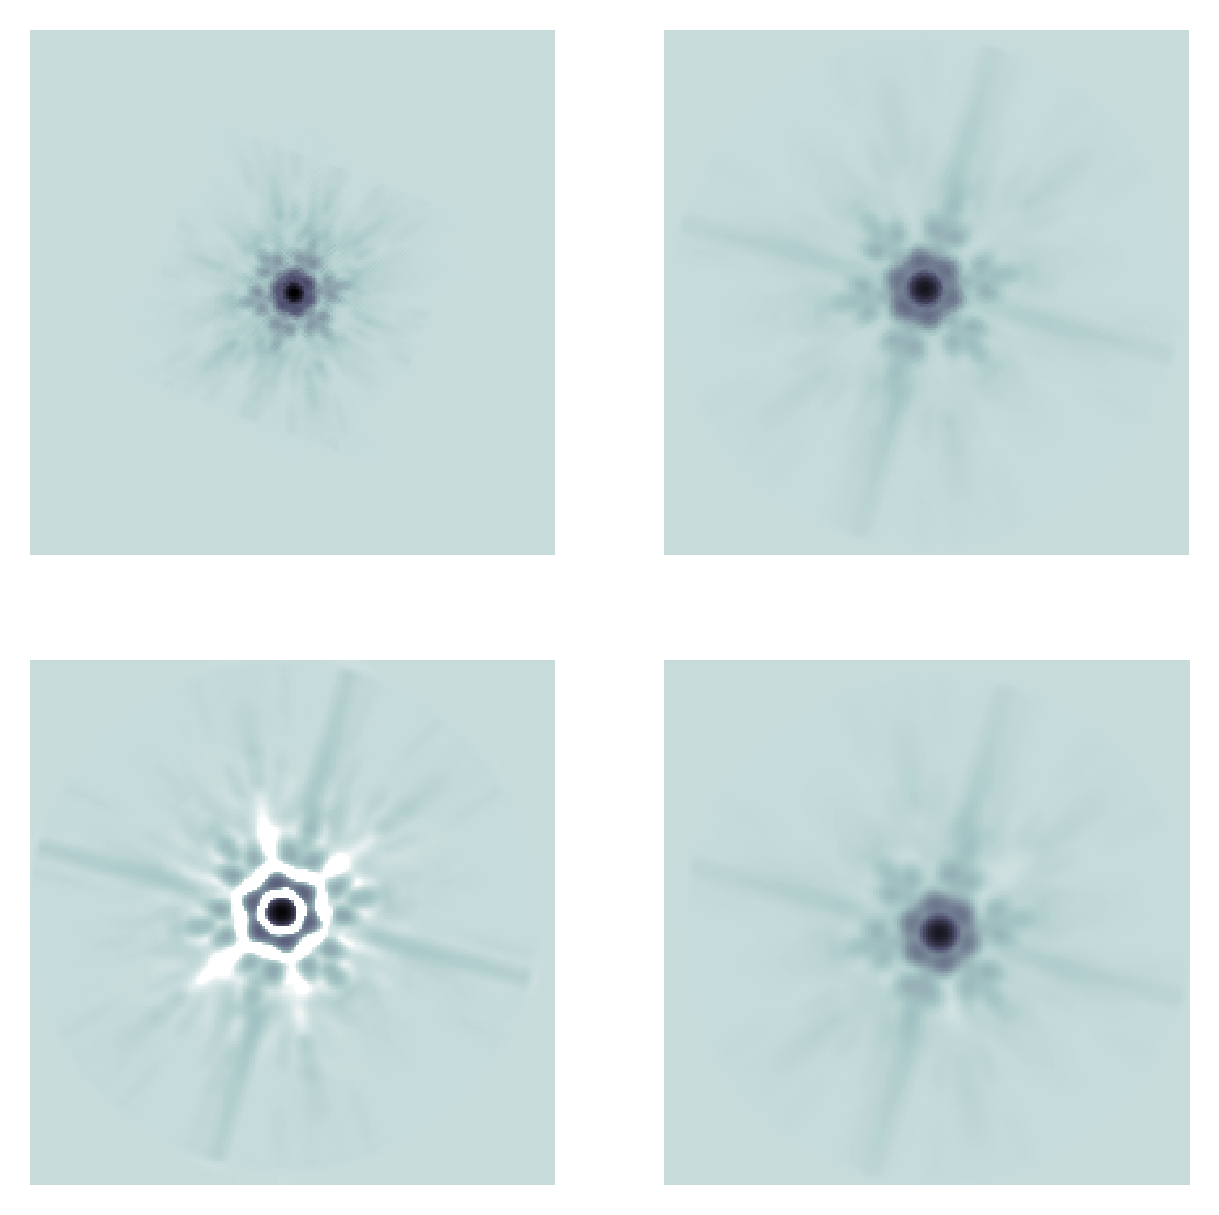

In [ ]:
from mophongo.templates import _convolve2d
from astropy.io import fits

# load region maps and associated psfs/kerneps if .fits files exist
prm1  = PSFRegionMap.from_geojson('../data/uds-test_f444w_psf.geojson')
prm2  = PSFRegionMap.from_geojson('../data/uds-test_f770w_psf.geojson')
prmk  = PSFRegionMap.from_geojson('../data/uds-test_kernel_f444w_to_f770w.geojson')
 
# test kernel lookup for region 0 by extracting the ra, dec, and region index
i=0
ra, dec = prmk.regions.loc[i].geometry.centroid.xy
psf_index = prmk.regions.loc[i].psf_key

# should give idx_k = 0, with idx_1 and idx_2 being the keys for the PSFs in prm1 and prm2 
idx_k  = prmk.lookup_key(ra[0], dec[0])
idx_1, idx_2 = prmk.regions.loc[psf_index][['psf_key_1', 'psf_key_2']]
print(i, psf_index, ra[0], dec[0], idx_k, idx_1, idx_2)

# extract psfs and kernel at ra,dec for region i
psf1 = prm1.psfs[idx_1]
psf2 = prm2.psfs[idx_2]
kernel = prmk.psfs[idx_k]

# convolve PSF with kernel
psf1c =  _convolve2d(psf1, kernel)

kws = dict(vmin=-5.3, vmax=-1.5, cmap='bone_r', origin='lower', interpolation='nearest')
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
for a in ax: a.set_axis_off()
ax[0].imshow(np.log10(psf1+2e-5),**kws)
ax[1].imshow(np.log10(psf2+2e-5),**kws)
ax[2].imshow(np.log10(kernel+2e-5),**kws)
ax[3].imshow(np.log10(psf1c+2e-5),**kws)


## Fast kernel recall

In [24]:
from mophongo import PSFRegionMap

fname = '../data/uds-test_kernel_f444w_to_f770w'
prm  = PSFRegionMap.from_geojson(fname+'.geojson')
prm.psfs